In [541]:
import os
import json

import random

import sys
from typing import List, Tuple, TypeVar, Dict, NoReturn, Iterable, Union, Iterator, overload, Generator

from pathlib import Path

from keras import Input

import bots.rl18730

resources_file_path: Path = Path().cwd()

print(str(resources_file_path.parent/"rl18730.py"))

sys.path.append(str(resources_file_path.parent/"rl18730.py"))


from bots.rl18730 import PlayerRecord, GameRecordHistory, GameRecord, PlayerRecordNNEstimator,\
    RoleAllocationEnum, GamestateTree, TPlayer, gamerecord_history_unpickler

import bots.rl18730 as rl18730

print(rl18730.__dict__)

#sys.modules["GameRecordHistory"] = GameRecordHistory
#sys.modules["PlayerRecordNNEstimator"] = PlayerRecordNNEstimator
#sys.modules["RoleAllocationEnum"] = RoleAllocationEnum
#sys.modules["GamestateTree"] = GamestateTree
#sys.modules["TPlayer"] = TPlayer
import tensorflow as tf

from tensorflow import keras

from tensorflow.keras import layers, models

import numpy as np

import matplotlib.pyplot as plt




# https://datascience.stackexchange.com/questions/48796/how-to-feed-lstm-with-different-input-array-sizes

# https://keras.io/guides/understanding_masking_and_padding/

# TODO: load the PlayerRecordHolder pickle, use that data to train a model that can be put in PlayerRecordNNEstimator,
#   in order to estimate the likelihoods of each player being a spy.
#   validate the outputs of the model using the known spy info in the player records.
#   Remember to use the training set, test set, and validation set partitions present in PlayerRecordHolder,
#   to ensure that there's a good range of data being used.
# TODO: after that's done, save the model. Then, edit rl18730.py to load that model, and then use that model to
#   produce more refined player suspicion estimates.
# TODO: also compare the accuracy of the final neural network to the basic heuristic estimator already in PlayerRecord.
#   If the neural network turns out to be worse than the heuristic estimator, we don't bother with it.


M:\MSc\CE811\CE811_lowe_rachel_m\resistance_framework\bots\rl18730.py
{'__name__': 'bots.rl18730', '__doc__': None, '__package__': 'bots', '__loader__': <_frozen_importlib_external.SourceFileLoader object at 0x000001AC9A5E4E50>, '__spec__': ModuleSpec(name='bots.rl18730', loader=<_frozen_importlib_external.SourceFileLoader object at 0x000001AC9A5E4E50>, origin='M:\\MSc\\CE811\\CE811_lowe_rachel_m\\resistance_framework\\bots\\rl18730.py'), '__file__': 'M:\\MSc\\CE811\\CE811_lowe_rachel_m\\resistance_framework\\bots\\rl18730.py', '__cached__': 'M:\\MSc\\CE811\\CE811_lowe_rachel_m\\resistance_framework\\bots\\__pycache__\\rl18730.cpython-39.pyc', '__builtins__': {'__name__': 'builtins', '__doc__': "Built-in functions, exceptions, and other objects.\n\nNoteworthy: None is the `nil' object; Ellipsis represents `...' in slices.", '__package__': '', '__loader__': <class '_frozen_importlib.BuiltinImporter'>, '__spec__': ModuleSpec(name='builtins', loader=<class '_frozen_importlib.BuiltinImport

TODO: load the PlayerRecordHolder pickle, use that data to train a model that can be put in PlayerRecordNNEstimator,
in order to estimate the likelihoods of each player being a spy.
validate the outputs of the model using the known spy info in the player records.
Remember to use the training set, test set, and validation set partitions present in PlayerRecordHolder,
to ensure that there's a good range of data being used.

TODO: after that's done, save the model. Then, edit rl18730.py to load that model,
  and then use that model to produce more refined player suspicion estimates.

TODO: also compare the accuracy of the final neural network to the basic heuristic estimator already in PlayerRecord.
  If the neural network turns out to be worse than the heuristic estimator, we don't bother with it.


NEURAL NETWORK STRUCTURE:

    Inputs:
        5 * ??? * 20
            5 players, ??? rounds, 20 wide per round
    Outputs:

In [542]:
NN_TUPLE = Tuple[
    float, float, float, float, float, int,
    int, int, int, int, int, int, int,
    int, int, int, int, int, int, int,
]
"""
A type alias for the tuple representing the inputs into the neural network
for a single player at the given gamestate
"""

NN_5TUPLE = Tuple[NN_TUPLE, NN_TUPLE, NN_TUPLE, NN_TUPLE, NN_TUPLE]
"""
A type alias for the tuple representing the vector of 5 inputs into the neural network for the given gamestate.
Yes, it's literally just a tuple of 5 NN_TUPLES.
"""

HSD_TUPLE = Tuple[float, float, float, float, float]
"""
A type alias for the heuristic suspicion dict return values
Yes, it's a tuple of 5 floats. But you'll probably be seeing it a lot.
"""

LABEL_TUPLE= Tuple[int, int, int, int, int]
"""
This is a type alias for the one-hot encoded spy vector, which is effectively being used as the label when testing the
neural network.
"""

GAMESTATE_DICT_DATA = Union[Tuple[NN_5TUPLE], Tuple[HSD_TUPLE], LABEL_TUPLE]
"""
A type alias for the actual data held in the keys of the dictionaries that will be decoded from the JSON
in the logs
"""

GAMESTATE_DICT = Dict[str, GAMESTATE_DICT_DATA]
"""
A type alias for the dictionaries themselves that need to be read from the JSON.
"""

IND_GS_DATA = Tuple[NN_5TUPLE, LABEL_TUPLE, HSD_TUPLE]
"""
a type alias for the data from a single element of a gamestate.
"""


IND_GS_NN_LABELS = Tuple[NN_5TUPLE, LABEL_TUPLE]
"""

You might currently think that these type aliases were a waste of time. But you'll thank me later.
"""


"\n\nYou might currently think that these type aliases were a waste of time. But you'll thank me later.\n"

In [543]:

class JsonGamestateDictDecoder(object):
    """
    only here because unpickling doesn't work
    """

    def __init__(self, json_strings: Iterable[str]) -> None:
        """
        Attempts to load the iterator of JSON stringed GAMESTATE_DICTs into a tuple of GAMESTATE_DICT objects.
        :param json_strings: an iterator of JSON string format GAMESTATE_DICT dictionaries
        """
        # noinspection PyTypeChecker
        self._game_records: Tuple[GAMESTATE_DICT] = tuple(
            d for d in (
                json.loads(j) for j in json_strings
            )
        )

    @property
    def get_records(self) -> Tuple[GAMESTATE_DICT]:
        """
        Obtains all of the records held in this PlayerRecordHolder
        :return: the list of all the records in this holder (arranged per game)
        """
        return self._game_records

    def get_training_set_and_test_set_and_validation_set(
            self, training_size: float = 0.4, test_size: float = 0.4
    ) -> Tuple[
        Tuple[GAMESTATE_DICT],
        Tuple[GAMESTATE_DICT],
        Tuple[GAMESTATE_DICT],
    ]:
        """
        Attempts to create a training set and a validation set from the data we have.
        :param training_size: what proportion of our data are we putting into our training set?
        :param test_size: what proportion of our data are we putting into our test set?
        :return: a tuple with (training set data, test set data, validation set data)
        """

        rec_len: int = len(self._game_records)

        training_len: int = int(rec_len * training_size)
        test_len: int = int(rec_len * test_size)

        tt_len: int = training_len + test_len

        val_len: int = rec_len - tt_len

        assert training_len > 0
        assert test_len > 0
        assert val_len > 0

        shuffled_all: List[GAMESTATE_DICT] = random.sample(self._game_records, rec_len)

        return tuple(shuffled_all[0:training_len]), tuple(shuffled_all[training_len:tt_len]), tuple(shuffled_all[tt_len:rec_len])

log_file = open("heuristic bayes training data log.log","r")

grh_dec: JsonGamestateDictDecoder = JsonGamestateDictDecoder(log_file)
log_file.close()

data_sets: Tuple[Tuple[GAMESTATE_DICT], Tuple[GAMESTATE_DICT], Tuple[GAMESTATE_DICT]] = grh_dec.get_training_set_and_test_set_and_validation_set()


In [544]:
# TODO: make and train a neural network, compare outputs of that
# to the heuristic suspicion outputs

In [545]:


class DataStore(Iterable["DataStore.IndividualDataset"]):
    """
    A class that basically holds the same data as the list of gamestate dicts, but in a more useful way.
    Because this time, it now stores them as IndividualDatasets!
    """

    class IndividualDataset(Iterable[IND_GS_DATA]):
        """
        The dataset for an individual game.

        It has an iterator to allow each individual gamestate's gamestate data to be iterated through.
        """

        @classmethod
        def from_data_dict(cls, data_dict: GAMESTATE_DICT) -> "DataStore.IndividualDataset":
            """
            Use this to construct the class from a GAMESTATE_DICT format dictionary
            :param data_dict: the dict of data that we want to turn into an IndividualDataset
            :return: an IndividualDataset that represents the data held in the GAMESTATE_DICT
            """
            return DataStore.IndividualDataset(
                tuple(data_dict["spies"]), tuple(data_dict["nn_in"]), tuple(data_dict["hsd_out"])
            )

        def __init__(
                self,
                labels: LABEL_TUPLE,
                nn_inputs: Tuple[NN_5TUPLE],
                hsd_outputs: Tuple[HSD_TUPLE]
        ):
            """
            Constructs this class to hold the contents of the data_dict in a slightly more managable format
            :param data_dict: the unjsoned json log string from the log file produced by the rl18730 bot
            """
            # noinspection PyTypeChecker
            self._labels: LABEL_TUPLE = labels

            # noinspection PyTypeChecker
            self._nn_inputs: Tuple[NN_5TUPLE] = nn_inputs

            # noinspection PyTypeChecker
            self._hsd_outputs: Tuple[HSD_TUPLE] = hsd_outputs


        @property
        def labels(self) -> LABEL_TUPLE:
            """Obtain the label tuple for this individual dataset."""
            return self._labels

        @property
        def nn_inputs(self) -> Tuple[NN_5TUPLE]:
            """Obtain the NN inputs tuple for this individual dataset"""
            return self._nn_inputs

        @property
        def hsd_outputs(self) -> Tuple[HSD_TUPLE]:
            """Obtain the heuristic suspicion dict tuple for this individual dataset"""
            return self._hsd_outputs

        @property
        def training_data_generator(self) -> Iterator[Tuple[np.ndarray, np.ndarray]]:
            """
            A generator that produces all of the possible training data for this individual record
            :return: a tuple containing a list of the NN inputs for this state, along with a label tuple for this state.
            Each iteration of this generator, the next NN_5TUPLE in the inputs tuple is added to the Iterable[NN_5TUPLE]
            in the output.
            """
            inputs: np.ndarray = np.empty(shape=(1,5,20))
            for i in self.indices:
                inputs = np.concatenate((inputs, np.array((self._nn_inputs[i]))), axis=0)
                yield inputs, np.array(self._labels)

        @property
        def np_inputs_generator(self) -> Iterator[np.ndarray]:
            """
            A generator that's only for the inputs
            :return:
            """
            inputs: np.ndarray = np.empty(shape=(1,5,20))
            for i in self.indices:
                #inputs = np.concatenate((inputs, np.array(tuple(self._nn_inputs[i]))), axis=0)
                yield np.array(self._nn_inputs[i])
                # np.stack([np.array(inp) for inp in self._nn_inputs[0:i+1]]) #inputs

        @property
        def simpler_np_inputs_generator(self) -> Iterator[np.ndarray]:
            for i in self.indices:
                yield np.array(self._nn_inputs[i])
                #yield tuple(
                #    np.array(t) for t in self._nn_inputs[i]
                #)

        @property
        def tf_ragged_inputs_generator(self) -> Iterator[tf.ragged.constant]:
            for i in self.indices:
                #inputs = np.concatenate((inputs, np.array(tuple(self._nn_inputs[i]))), axis=0)
                yield tf.ragged.constant([np.array(inp) for inp in self._nn_inputs[0:i+1]]) #inputs

        @property
        def np_ragged_generator(self) -> Iterator[np.ndarray]:
            for i in self.indices:
                return np.stack([np.array(inp) for inp in self._nn_inputs[0:i+1]])

        @property
        def np_labels_generator(self) -> Iterator[np.ndarray]:
            for i in self.indices:
                yield np.array(self.labels)

        def simpler_np_inputs_also_labels_generator(self) -> Generator[Tuple[np.ndarray, np.ndarray], None, None]:
            for i in self._nn_inputs:
                yield np.array(i).T, np.array(self.labels)


        def np_inputs_2(self) -> Iterator[np.ndarray]:
            for i in self._nn_inputs:
                yield np.array(i)

        def np_labels_2(self) -> Iterator[np.ndarray]:
            for i in self._nn_inputs:
                yield np.array(self.labels)



        @overload
        def __getitem__(self, key: int) -> IND_GS_DATA:
            """
            Overload for getitem when an int is given.
            Returns neural network inputs for the nth gamestate,
            along with the hsd outputs for the nth gamestate,
            accompanied by the labels for the nth gamestate via ind_ds[n]
            :param key: nth gamestate (starting at 0).
            :return: tuple with that gamestate's neural network inputs, the labels for the neural network input,
            and the heuristic suspicion outputs tuple for that gamestate
            """
            pass

        @overload
        def __getitem__(self, key: slice) -> "DataStore.IndividualDataset":
            """
            Overload for getitem when a slice is given
            Returns a Dataset.IndividualDataset retaining only the part of nn_inputs and hsd_outputs
            described by the slice.
            :param key: slice with details about the desired slice.
            :return: IND_GS_SLICE_DATA for the given slice info.
            """
            pass

        def __getitem__(self, key):
            """
            Makes it easier to get the neural network inputs for the nth gamestate,
            along with the hsd outputs for the nth gamestate, accompanied by the labels for the nth gamestate
            via ind_ds[n]
            :param key: if an int, will obtain the item at nth gamestate (starting at 0).
            if a slice, will return a new IndividualDataset, holding only the specified slice of nn_inputs and hsd_outputs
            :return: tuple with that gamestate's neural network inputs, the labels for the neural network input,
            and the heuristic suspicion outputs tuple for that gamestate
            """
            if type(key) == slice:
                return DataStore.IndividualDataset(self.labels, self._nn_inputs[key], self._hsd_outputs[key])
            elif type(key) == int:
                return self._nn_inputs[key], self._labels, self._hsd_outputs[key]

        def __len__(self) -> int:
            """Helper function to return how many gamestates in total are in this individual dataset"""
            return self._hsd_outputs.__len__()

        def __iter__(self) -> Iterator[IND_GS_DATA]:
            """Helper function to return an iterator to iterate through the data for each gamestate in this dataset"""
            return DataStore.IndividualDataset.IndividualDatasetIterator(self)

        @property
        def indices(self) -> range:
            """Returns a range object between 0 and len, giving all valid indices for getitem or slicing etc"""
            return range(0, self._hsd_outputs.__len__())


        class IndividualDatasetIterator(Iterator[IND_GS_DATA]):
            """
            An iterator for an IndividualDataset object,
            returning the individual gamestate data
            (neural network inputs for each player, labels, HSD estimation for each player)
            """

            def __init__(self, i_ds: "DataStore.IndividualDataset"):
                """
                Constructor, sets self._i to 0, and obtains a copy of the dataset
                :param i_ds: the dataset to iterate through
                """
                self._ds: "DataStore.IndividualDataset" = i_ds
                self._i: int = 0

            def __next__(self) -> IND_GS_DATA:
                """
                Iterates through the individual dataset object,
                returning the result of self._ds[self._i] for each value of self._i,
                until self._i >= self._ds.len()
                :return: individual gamestate data for the current gamestate of the dataset
                """
                if self._i >= self._ds.__len__():
                    raise StopIteration
                data: IND_GS_DATA = self._ds[self._i]
                self._i += 1
                return data



    def __init__(self, datasets: Tuple[GAMESTATE_DICT]):
        """
        Initialiser for this object
        :param datasets: the tuple of GAMESTATE_DICTs that we are turning into IndividualDatasets
        """
        self._datasets: Tuple[DataStore.IndividualDataset] = tuple(
            DataStore.IndividualDataset.from_data_dict(d) for d in datasets
        )
        pass

    @property
    def datasets(self) -> Tuple["DataStore.IndividualDataset"]:
        """Obtains the tuple of individualdatasets held within this dataset"""
        return self._datasets

    def __len__(self) -> int:
        """gets the length of the datasets tuple"""
        return self._datasets.__len__()

    def __iter__(self) -> Iterator["DataStore.IndividualDataset"]:
        """generates an iterator through the datasets held within this"""
        return self._datasets.__iter__()

    @property
    def training_data_generator(self) -> Tuple[np.ndarray, np.ndarray, int]:
        """Generator that generates training data with labels and batch size to give to the model"""
        inputs: np.ndarray = np.empty(shape=(1,5,20))
        labels: np.ndarray = np.empty(shape=(1,5))

        for ds in self:
            for i_l in ds.training_data_generator:
                inputs = np.concatenate((inputs, i_l[0]), axis=0)
                labels = np.concatenate((labels, [i_l[1]]), axis=1)
        return inputs, labels, labels.shape[1]

    @property
    def np_inputs_generator(self) -> Generator[np.ndarray, None, None]:
        for ind in self:
            for i in ind.np_inputs_generator:
                yield i

    @property
    def np_simpler_inputs_generator(self) -> Generator[np.ndarray, None, None]:
        for ind in self:
            for i in ind.simpler_np_inputs_generator:
                yield i

    @property
    def tf_ragged_inputs_generator(self) ->  tf.ragged.constant:

        return tf.ragged.constant(
            tuple(ind.np_ragged_generator for ind in self)
        )

    @property
    def np_labels_generator(self) -> Generator[np.ndarray, None, None]:
        for ind in self:
            for l in ind.np_labels_generator:
                yield l


    def inputs_and_labels_generator(self) -> Iterator[Tuple[np.ndarray, np.ndarray]]:
        for ind in self:
            for t in ind.simpler_np_inputs_also_labels_generator():
                yield t

    def np_inputs_2(self) -> Iterator[np.ndarray]:
        for ind in self:
            for i in ind.np_inputs_2():
                yield i

    def np_labels_2(self) -> Iterator[np.ndarray]:
        for ind in self:
            for i in ind.np_labels_2():
                yield i

    def np_in_lab_2(self) -> Tuple[List[np.ndarray], List[np.ndarray]]:
        return list(self.np_inputs_2()), list(self.np_labels_2())


    @staticmethod
    def np_gen_stacker(gen: Generator[np.ndarray, None, None]) -> np.ndarray:
        """
        Give this an iterator of ndarrays, and it'll vstack them into a single ndarray
        :param gen: generator of stuff we want to stack
        :return: stacked contents of that iterator
        """
        return np.stack(list(gen))



training_dataset: DataStore = DataStore(data_sets[0])
test_dataset: DataStore = DataStore(data_sets[1])
validation_dataset: DataStore = DataStore(data_sets[2])

print(len(training_dataset))
print(len(test_dataset))
print(len(validation_dataset))

1780
1780
890


In [546]:

#training_ds: tf.data.Dataset = tf.data.Dataset.from_generator(
#    training_dataset.inputs_and_labels_generator(),
#    output_signature=Tuple[np.ndarray,np.ndarray]
#)


# x_train = training_ds.as_numpy_iterator()


In [547]:
x_train = list(training_dataset.np_inputs_2())
#training_dataset.tf_ragged_inputs_generator
#print(x_train.bounding_shape)
#print(x_train.shape)
#max_len = 25

#x_train = training_dataset.np_simpler_inputs_generator()

#print(list(x_train))

print(len(list(x_train)))



12699


In [548]:
y_train = list(training_dataset.np_labels_2())

In [549]:
train_len = len(list(x_train))
print(train_len)

12699


In [550]:
the_model: keras.Model = keras.Sequential(name="rnn_predictor_model")

#f_sequence = Input(shape=(x_train.shape[0], 25))

#layer_1: layers.LSTM = layers.LSTM(40, activation="tanh", time_major=True, stateful=False)
# layer_1: layers.Dense
#inputs: layers.InputLayer = layers.InputLayer(input_shape=(20,5,))
layer_2: layers.Dense = layers.Dense(40, activation=keras.activations.relu,input_shape=(20,))
layer_3: layers.Dense = layers.Dense(20, activation=keras.activations.relu,input_shape=(40,))
layer_4: layers.Dense = layers.Dense(10, activation=keras.activations.relu,input_shape=(20,))
sm_layer: layers.Dense = layers.Dense(1, activation=keras.activations.relu, input_shape=(10,))

#the_model.add(layer_1)
#the_model.add(inputs)
the_model.add(layer_2)
the_model.add(layer_3)
the_model.add(layer_4)
the_model.add(sm_layer)

print(the_model.summary)

<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001ACA6914220>>


In [551]:
eta = 0.01

epochs = 400

In [552]:
the_model.compile(
    optimizer = keras.optimizers.Adam(eta),
    loss = keras.losses.MeanSquaredError(),
    metrics = "accuracy"
)


In [553]:
np_x = np.array(x_train)

print(np_x.shape)
print(np_x[0])

#np_x = np.swapaxes(np_x, 1,2)
print(np_x.shape)
#print(np_x[0])
#np_x = np.swapaxes(np_x, 2,0)


#np_x = np_x.reshape(np_x.shape[0]*np_x.shape[1], np_x.shape[2])

print(np_x.shape)

print(np_x)




(12699, 5, 20)
[[ 0.5        -0.33333333  0.5        -0.33333333  1.          0.
   0.          0.          0.          0.          0.          0.
   1.          1.          0.          0.          0.          0.
   0.          0.        ]
 [-0.33333333 -0.33333333 -0.33333333 -0.33333333  0.33333333  0.
   1.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [-0.33333333 -0.33333333 -0.33333333 -0.33333333  0.25        0.
   1.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [-0.33333333 -0.33333333 -0.33333333 -0.33333333  0.4         0.
   1.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.5        -0.33333333 -0.33333333 -0.33333333  0.5         0.
   1.          0.  

In [554]:
np_y = np.array(y_train)

print(np_y.shape)

np_y = np.reshape(np_y, (np_y.shape[0], np_y.shape[1], 1))

print(np_y[0])
print(np_y.shape)

(12699, 5)
[[0]
 [0]
 [1]
 [1]
 [0]]
(12699, 5, 1)


In [555]:

history = the_model.fit(
    np_x,
    np_y,
    train_len,
    epochs = 1000,
    verbose = 0
)


[[ 0.5        -0.33333333  0.5        -0.33333333  1.          0.
   0.          0.          0.          0.          0.          0.
   1.          1.          0.          0.          0.          0.
   0.          0.        ]
 [-0.33333333 -0.33333333 -0.33333333 -0.33333333  0.33333333  0.
   1.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [-0.33333333 -0.33333333 -0.33333333 -0.33333333  0.25        0.
   1.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [-0.33333333 -0.33333333 -0.33333333 -0.33333333  0.4         0.
   1.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.5        -0.33333333 -0.33333333 -0.33333333  0.5         0.
   1.          0.          0.     

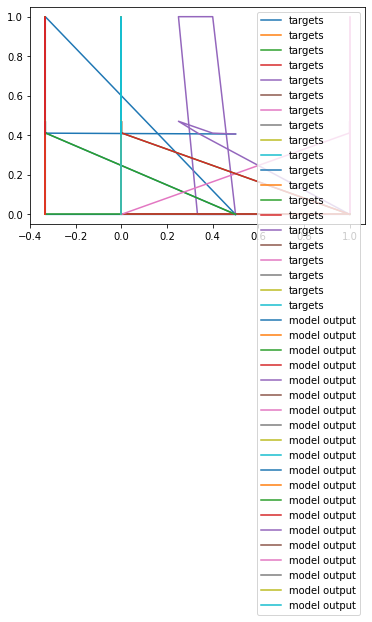

In [556]:
print("{} {}".format(np_x[5], np_y[5].ravel()))
print("{} {}".format(np_x[5], the_model(np_x[5]).numpy()))

plt.plot(np_x[4], np_y[4].ravel(), label = "targets")
plt.plot(np_x[4], the_model(np_x[4]).numpy(),label="model output")
plt.legend()
